# Processing of Cell Viability Data
### Merino Pipeline

In this workbook we will take a look at the data processing pipeline for cell viability data from the PRISM assay. Starting with raw fluoresence intensity from Luminex bead scans, we take the data through five levels of organization and normalization, finishing with a weighted average of differential viability values from several biological replicates. The data levels are as follows:

Level 1: Bead identity and raw fluoresence intensity in LXB format
Level 2: Median Fluoresence Intensity per cell line in GCT format with associated metadata
Level 3: Data normalized to control barcodes and logged 
Level 4: Differential viability calculated with Zscore or Fold Change (several variants at this level)
Level 5: Weighted average of differential viability profiles from replicate set, adjusted with COMBAT to correct for any batch effects from cell pooling. 

### Importing necessary python packages

In [1]:
import glob
import os
import pandas as pd
import cmapPy.pandasGEXpress.write_gct as wg
from cmapPy.pandasGEXpress import parse as pe
from cmapPy.pandasGEXpress import GCToo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF


In [2]:
import warnings
warnings.filterwarnings("ignore")
import merino.card.normalize_with_prism_invariant as norm
import merino.card.viability_normalization as fold_change
import merino.build_summary.invariant_analysis as inv
import merino.normalization.distil as distil
import merino.normalization.batch_adjust as batch_adjust
import merino.build_summary.ssmd_analysis as ssmd
import merino.card.zscore as zscore

# Reading in Level 2 Data
## Rationale 

We start here by reading in Level 2. Level 1 data comprises the bead identity and raw fluorescent intensity (FI) values measured for every bead detected by the Luminex scanner. These are stored in a file format known as LXB. The FI is proportional to the amount of amplicon bound to the bead, and hence is also proportional to the barcode transcript abundance of the cell line that particular bead is interrogating. 

We don't show the transition from level 1 to level 2 here, because unlike in L1000 the values contained at these levels are identical. There is only one cell line per bead, so no deconvolution is necessary and we simply take the median fluorsence intensity (MFI) for each cell line in each sample. Transition from level 1 to level 2, called "assemble" simply extracts these values and aranges them in a gct file with the appropriate metadata. 

In [3]:
# Read in Level 2 data for processing. These are median fluoresence intensity values(mfi).
BASE_PATH = os.path.expanduser('~/data/pfc')
rep1_path = os.path.join(BASE_PATH,'input/assemble/PASG003_CS5_X251/PASG003_CS5_X251_MEDIAN.gct')
rep2_path = os.path.join(BASE_PATH,'input/assemble/PASG003_CS5_X252/PASG003_CS5_X252_MEDIAN.gct')
rep3_path = os.path.join(BASE_PATH,'input/assemble/PASG003_CS5_X253/PASG003_CS5_X253_MEDIAN.gct')


rep1_mfi = pe.parse(rep1_path)
rep2_mfi = pe.parse(rep2_path)
rep3_mfi = pe.parse(rep3_path)

In [4]:
rep2_mfi.data_df.head()

cid,PASG003_CS5_X252:A01,PASG003_CS5_X252:A02,PASG003_CS5_X252:A03,PASG003_CS5_X252:A04,PASG003_CS5_X252:A05,PASG003_CS5_X252:A06,PASG003_CS5_X252:A07,PASG003_CS5_X252:A08,PASG003_CS5_X252:A09,PASG003_CS5_X252:A10,...,PASG003_CS5_X252:P15,PASG003_CS5_X252:P16,PASG003_CS5_X252:P17,PASG003_CS5_X252:P18,PASG003_CS5_X252:P19,PASG003_CS5_X252:P20,PASG003_CS5_X252:P21,PASG003_CS5_X252:P22,PASG003_CS5_X252:P23,PASG003_CS5_X252:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,20403.5,24875.0,14717.0,22875.0,16990.0,31404.0,11703.5,9473.0,10916.5,36807.0,...,20001.0,22541.5,12844.0,20323.0,1057.0,16656.5,19736.5,508.0,22415.0,18530.0
c-2,5420.0,3263.0,6483.0,9846.0,4037.0,5128.0,6500.0,3775.0,1718.0,4402.0,...,4325.0,7683.0,2153.0,2667.5,5767.0,2301.0,3502.5,4314.0,4246.5,4075.0
c-3,5993.0,1980.0,2509.5,4580.0,2692.0,3202.0,2647.0,3850.0,1664.5,7304.0,...,2903.0,2988.0,1983.0,2735.0,1350.0,1460.5,4017.0,5020.0,2740.5,3650.0
c-4,7875.5,6092.0,5354.5,12482.0,6823.0,15573.0,4528.0,3105.0,4008.5,9490.5,...,9021.0,7994.0,4529.0,7027.0,12047.0,6295.0,6884.0,9910.0,7836.5,4167.0
c-5,9591.5,7324.0,6338.0,13345.0,4726.0,12611.0,4006.0,5429.5,4624.0,12160.5,...,11004.0,8829.0,5504.0,5804.5,5284.0,6140.0,7272.0,5845.0,7106.0,6264.5


## MFI Distribution

Median fluoresence intensity values range from 0 to ~50000

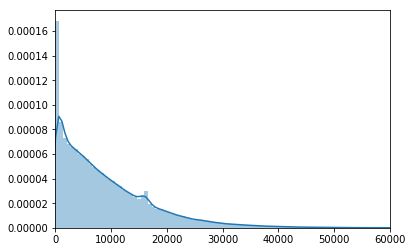

In [5]:
sns.distplot(rep1_mfi.data_df.unstack(), 100)
plt.xlim(0,60000)
plt.show()

# Control Barcodes
## Rationale 

In amplification and detection there is necessarily some well to well variation introduced. To account for this, a series of ten monotonically increasing control barcodes are introduced. The same amount of these is added to every well, so variation between the control barcodes should reflect well to well variation introduced by amplification and detection.

Lets take a look at their curves by well below. You'll notice that wells with PosCons in them consistently have high MFI in their invariant curves, while negative controls have lowe MFI. This is because wells in which most of the cell lines have been killed have less competition for reagents, and the surviving cell line (and control barcodes) become more amplified than their counterparts in wells with lots of competition for reagents (such as negative controls). 

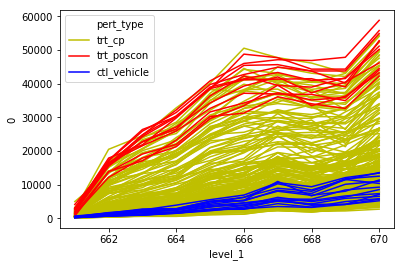

In [6]:
inv_df = inv.extract_invariants(rep2_mfi)
inv_df.data_df.index = [int(x.replace('c-', '')) for x in inv_df.data_df.index]

plot_invs = inv_df.data_df.unstack().reset_index().set_index('cid').join(rep2_mfi.col_metadata_df[['pert_type']]).reset_index()

sns.lineplot(x="level_1", y=0, hue="pert_type",data=plot_invs, estimator=None, units="cid", sort=True
             , hue_order=['trt_cp', 'trt_poscon','ctl_vehicle'],palette=[ 'y', 'r', 'b'])
plt.legend(loc='upper left')
plt.show()



# Level 2 (MFI) to Level 3 (NORM)
## Rationale 

At level three we make two major adjustments to the data. First we divide each well by the median of its ten control barcodes in order to control for the well to well variation described above. We see that this cleans up data and greatly improves important QC checks like SSMDs (Strictly Standardized Median Difference between positive and negative controls). At this point we also put the data on a log scale.





\begin{equation*}
N_{c,w} = log_{2}(X_{c,w}) - log_{2}(Median(C_{w})) \\
\text{ where } C_{w} \text{ are the MFI of control barcodes in } w
\end{equation*}



In [7]:
# Normalize mfi values with control barcodes to get level 3 data. 
rep1_norm = norm.normalize(rep1_mfi)
rep2_norm = norm.normalize(rep2_mfi)
rep3_norm = norm.normalize(rep3_mfi)

In [8]:
rep1_norm.data_df.head()

cid,PASG003_CS5_X251:A01,PASG003_CS5_X251:A02,PASG003_CS5_X251:A03,PASG003_CS5_X251:A04,PASG003_CS5_X251:A05,PASG003_CS5_X251:A06,PASG003_CS5_X251:A07,PASG003_CS5_X251:A08,PASG003_CS5_X251:A09,PASG003_CS5_X251:A10,...,PASG003_CS5_X251:P15,PASG003_CS5_X251:P16,PASG003_CS5_X251:P17,PASG003_CS5_X251:P18,PASG003_CS5_X251:P19,PASG003_CS5_X251:P20,PASG003_CS5_X251:P21,PASG003_CS5_X251:P22,PASG003_CS5_X251:P23,PASG003_CS5_X251:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,2.791579,2.475022,2.646518,1.279385,2.418991,3.030354,-1.536691,0.023251,3.180828,3.047542,...,3.153226,2.747144,3.157645,3.492647,-2.303412,2.679223,3.160970,-2.934454,2.832367,1.975594
c-2,0.699605,0.453574,0.153553,0.570492,0.536163,1.370399,-2.369097,-0.243949,0.928017,0.487517,...,0.194374,0.792891,0.859059,0.338758,1.395696,0.430806,0.902376,-0.355388,0.559792,0.155190
c-3,-0.278438,0.796275,0.837733,-0.120795,-0.349013,-0.101776,-3.627008,-1.213020,0.341319,-0.761855,...,0.775684,-0.056830,0.777408,1.326060,-2.095140,0.749519,0.905635,-0.714405,0.797161,-1.024588
c-4,1.311654,1.310524,0.613115,0.559004,1.394437,1.688459,-3.318002,-0.499426,2.032640,1.591852,...,2.208950,1.794390,1.765245,1.797243,1.220625,1.203993,1.635592,1.185866,1.306963,0.710553
c-5,1.204976,1.768111,1.417868,0.909986,1.321378,1.901308,-2.781712,-0.422679,1.505677,1.880243,...,1.903515,1.670015,1.933272,2.400356,-0.685434,1.302968,1.002649,-0.435890,1.780506,0.799652


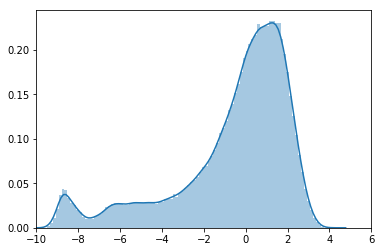

In [9]:
sns.distplot(rep1_norm.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

# QC Comparison - SSMDs

Here we compare the SSMD values for data before it is normalized by control barcodes and after it is normalized by control barcodes. Both are still using a linear scale. 

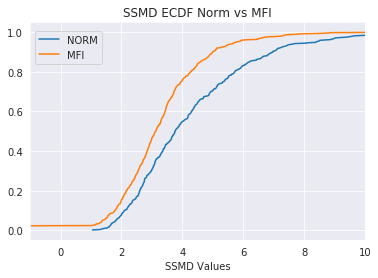

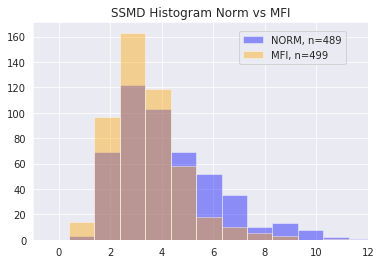

In [10]:
sns.set_style('darkgrid')
norm_ssmd = pd.Series()
median_ssmd = pd.Series()
norm_ssmd = ssmd.get_ssmd(rep1_norm,unlog=True)
median_ssmd = ssmd.get_ssmd(rep1_mfi)


norm_ecdf = ECDF(norm_ssmd)
med_ecdf = ECDF(median_ssmd)

plt.plot(norm_ecdf.x, norm_ecdf.y, label='NORM')
plt.plot(med_ecdf.x, med_ecdf.y, label='MFI')
plt.xlim(-1,10)
plt.xlabel('SSMD Values')
plt.title('SSMD ECDF Norm vs MFI')
axes = plt.gca()
axes.legend(bbox_to_anchor=(.015, 0.81, 0.8, .6), loc=3, borderaxespad=0.)
plt.show()


bines = np.linspace(min(norm_ssmd.dropna().append(median_ssmd.dropna())), max(norm_ssmd.dropna().append(median_ssmd.dropna())), 50)
n, bins, patches = plt.hist(norm_ssmd.dropna(), bines, facecolor='blue', alpha=.4, label='NORM, n={}'.format(len(norm_ssmd)))
n1, bins1, patches1 = plt.hist(median_ssmd.dropna(), bines, facecolor='orange', alpha=.4,
                                   label='MFI, n={}'.format(len(median_ssmd)))

plt.title('SSMD Histogram Norm vs MFI')
plt.xlim(-1,12)
axes = plt.gca()
axes.legend(bbox_to_anchor=(.615, 0.81, 0.8, .6), loc=3, borderaxespad=0.)
plt.show()

# Level 3 (NORM) to Level 4 (ZSPC, ZSVC, LFCPC, LFCVC)
## Rationale 

At level 4 we calculate differential data - the distance of each data point from a control for its feature. We calculate four variants of this data for comparison. First, the differential data can either be a Zscore or a log fold change, this is indicated by the ZS or LFC. Next, the control to which each data point is normalized can either be the median of DMSO negative controls for each cell line (Vehicle control denoted by VC), or the median of all wells on the plate for that cell line (Plate control, denoted by PC). In general we prefer Log Fold Change using Plate Control (LFCPC). 

### Plate Control based measures

##### Robust ZSCORE (ZSPC)

\begin{equation*}
ZSPC_{c,w} = \frac{N_{c,w} - Median(N_{c})}{1.4826 \times MAD(N_{c})} \\ 
\text{where MAD  is the median absolute deviation of } N\text{, and the factor} \\
\text{of 1.4826 makes the denominator a consistent estimator of scale for normally distributed data.}
\end{equation*}

##### Log Fold Change (LFCPC)

\begin{equation*}
LFCPC_{c,w} = N_{c,w} - Median(N_{c})
\end{equation*}


### Vehicle Control based measures

##### Robust ZSCORE (ZSVC)

\begin{equation*}
ZSVC_{c,w} = \frac{N_{c,w_{vehicle}} - Median(N_{c,w_{vehicle}})}{1.4826 \times MAD(N_{c,w_{vehicle}})}
\end{equation*}

##### Log Fold Change (LFCVC)


\begin{equation*}
LFCPC_{c,w} = N_{c,w} - Median(N_{c,w_{vehicle}})
\end{equation*}

In [11]:
rep1_zspc = zscore.calculate_zscore(rep1_norm, plate_control=True)
rep2_zspc = zscore.calculate_zscore(rep2_norm, plate_control=True)
rep3_zspc = zscore.calculate_zscore(rep3_norm, plate_control=True)

In [12]:
rep1_zspc.data_df.head()

cid,PASG003_CS5_X251:A01,PASG003_CS5_X251:A02,PASG003_CS5_X251:A03,PASG003_CS5_X251:A04,PASG003_CS5_X251:A05,PASG003_CS5_X251:A06,PASG003_CS5_X251:A07,PASG003_CS5_X251:A08,PASG003_CS5_X251:A09,PASG003_CS5_X251:A10,...,PASG003_CS5_X251:P15,PASG003_CS5_X251:P16,PASG003_CS5_X251:P17,PASG003_CS5_X251:P18,PASG003_CS5_X251:P19,PASG003_CS5_X251:P20,PASG003_CS5_X251:P21,PASG003_CS5_X251:P22,PASG003_CS5_X251:P23,PASG003_CS5_X251:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,0.481319,0.216314,0.359881,-0.784615,0.169407,0.681210,-3.142096,-1.836189,0.807180,0.695599,...,0.784072,0.444121,0.787772,1.068219,-3.783957,0.387260,0.790556,-4.312234,0.515465,-0.201783
c-10,-0.030695,-0.405301,-0.176282,-0.612019,0.089035,0.380505,-1.644190,-0.325870,-0.549047,0.302807,...,0.299902,0.572518,0.789429,1.103366,-0.540564,0.896254,0.684186,-1.190343,0.732717,0.303861
c-100,-0.282806,-0.108278,0.154236,0.461967,0.019426,0.642462,-1.335815,-0.591462,0.650698,0.174261,...,0.655492,-0.438518,0.544655,0.452097,0.000340,0.125351,-0.276205,-0.250953,-0.365515,-0.792170
c-101,-0.534667,-0.191953,-0.644880,-0.093741,0.065248,-0.068323,-3.208056,-0.868054,0.492983,0.671501,...,0.231818,0.419699,0.730147,0.913163,0.140916,0.588714,0.588149,-0.068794,0.200734,-0.151720
c-102,-0.107122,0.110974,-0.075938,-1.371834,0.312991,1.104997,-3.552290,-2.697576,0.270315,0.537103,...,-0.893751,0.154363,0.347081,1.223384,-0.928799,0.237474,0.233992,-0.187511,0.559710,0.385024


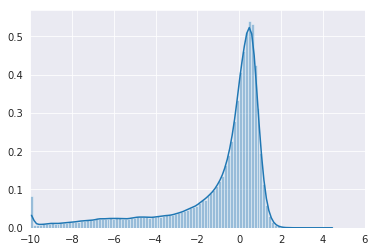

In [13]:
sns.distplot(rep1_zspc.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

In [14]:
rep1_lfcpc = fold_change.log_viability(rep1_norm, plate_control=True, log=True)
rep2_lfcpc = fold_change.log_viability(rep2_norm, plate_control=True, log=True)
rep3_lfcpc = fold_change.log_viability(rep3_norm, plate_control=True, log=True)

In [15]:
rep1_lfcpc.data_df.head()

cid,PASG003_CS5_X251:A01,PASG003_CS5_X251:A02,PASG003_CS5_X251:A03,PASG003_CS5_X251:A04,PASG003_CS5_X251:A05,PASG003_CS5_X251:A06,PASG003_CS5_X251:A07,PASG003_CS5_X251:A08,PASG003_CS5_X251:A09,PASG003_CS5_X251:A10,...,PASG003_CS5_X251:P15,PASG003_CS5_X251:P16,PASG003_CS5_X251:P17,PASG003_CS5_X251:P18,PASG003_CS5_X251:P19,PASG003_CS5_X251:P20,PASG003_CS5_X251:P21,PASG003_CS5_X251:P22,PASG003_CS5_X251:P23,PASG003_CS5_X251:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,0.574949,0.258393,0.429888,-0.937244,0.202361,0.813725,-3.753320,-2.193379,0.964198,0.830912,...,0.936596,0.530515,0.941015,1.276017,-4.520041,0.462593,0.944341,-5.151083,0.615737,-0.241035
c-10,-0.051565,-0.680873,-0.296139,-1.028144,0.149572,0.639219,-2.762109,-0.547435,-0.922355,0.508692,...,0.503812,0.961785,1.326178,1.853567,-0.908105,1.505635,1.149378,-1.999682,1.230907,0.510462
c-100,-0.326009,-0.124819,0.177798,0.532540,0.022394,0.740609,-1.539884,-0.681818,0.750103,0.200882,...,0.755630,-0.505509,0.627861,0.521162,0.000391,0.144501,-0.318400,-0.289290,-0.421354,-0.913187
c-101,-0.446612,-0.160340,-0.538673,-0.078303,0.054502,-0.057070,-2.679715,-0.725092,0.411792,0.560910,...,0.193639,0.350578,0.609898,0.762772,0.117708,0.491757,0.491285,-0.057464,0.167675,-0.126733
c-102,-0.109586,0.113526,-0.077684,-1.403380,0.320188,1.130407,-3.633976,-2.759608,0.276531,0.549454,...,-0.914303,0.157912,0.355062,1.251516,-0.950156,0.242935,0.239373,-0.191823,0.572580,0.393878


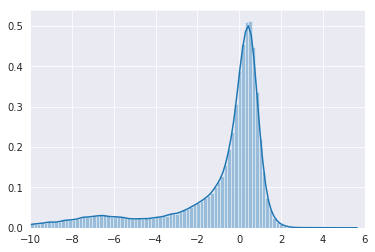

In [16]:
sns.distplot(rep1_lfcpc.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

In [17]:
rep1_lfcvc = fold_change.log_viability(rep1_norm, plate_control=False, log=True)
rep2_lfcvc = fold_change.log_viability(rep2_norm, plate_control=False, log=True)
rep3_lfcvc = fold_change.log_viability(rep3_norm, plate_control=False, log=True)

In [18]:
rep1_lfcvc.data_df.head()

cid,PASG003_CS5_X251:A01,PASG003_CS5_X251:A02,PASG003_CS5_X251:A03,PASG003_CS5_X251:A04,PASG003_CS5_X251:A05,PASG003_CS5_X251:A06,PASG003_CS5_X251:A07,PASG003_CS5_X251:A08,PASG003_CS5_X251:A09,PASG003_CS5_X251:A10,...,PASG003_CS5_X251:P15,PASG003_CS5_X251:P16,PASG003_CS5_X251:P17,PASG003_CS5_X251:P18,PASG003_CS5_X251:P19,PASG003_CS5_X251:P20,PASG003_CS5_X251:P21,PASG003_CS5_X251:P22,PASG003_CS5_X251:P23,PASG003_CS5_X251:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,-0.163772,-0.480329,-0.308833,-1.675965,-0.536360,0.075003,-4.492042,-2.932100,0.225477,0.092191,...,0.197875,-0.208207,0.202294,0.537296,-5.258763,-0.276128,0.205620,-5.889805,-0.122984,-0.979756
c-10,-0.954559,-1.583868,-1.199134,-1.931138,-0.753423,-0.263776,-3.665103,-1.450430,-1.825349,-0.394302,...,-0.399182,0.058790,0.423183,0.950573,-1.811100,0.602641,0.246383,-2.902677,0.327912,-0.392532
c-100,-0.935836,-0.734646,-0.432029,-0.077286,-0.587433,0.130783,-2.149710,-1.291644,0.140277,-0.408944,...,0.145804,-1.115335,0.018034,-0.088664,-0.609435,-0.465326,-0.928226,-0.899117,-1.031180,-1.523014
c-101,-0.960217,-0.673945,-1.052278,-0.591908,-0.459103,-0.570675,-3.193320,-1.238697,-0.101813,0.047305,...,-0.319966,-0.163027,0.096293,0.249167,-0.395896,-0.021848,-0.022320,-0.571069,-0.345930,-0.640338
c-102,-0.734499,-0.511388,-0.702598,-2.028294,-0.304725,0.505493,-4.258890,-3.384521,-0.348383,-0.075460,...,-1.539217,-0.467001,-0.269852,0.626602,-1.575070,-0.381979,-0.385541,-0.816737,-0.052333,-0.231036


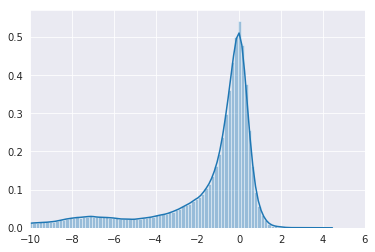

In [19]:
sns.distplot(rep1_lfcvc.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

In [20]:
rep1_zsvc = zscore.calculate_zscore(rep1_norm, plate_control=False)
rep2_zsvc = zscore.calculate_zscore(rep2_norm, plate_control=False)
rep3_zsvc = zscore.calculate_zscore(rep3_norm, plate_control=False)

In [21]:
rep1_zsvc.data_df.head()

cid,PASG003_CS5_X251:A01,PASG003_CS5_X251:A02,PASG003_CS5_X251:A03,PASG003_CS5_X251:A04,PASG003_CS5_X251:A05,PASG003_CS5_X251:A06,PASG003_CS5_X251:A07,PASG003_CS5_X251:A08,PASG003_CS5_X251:A09,PASG003_CS5_X251:A10,...,PASG003_CS5_X251:P15,PASG003_CS5_X251:P16,PASG003_CS5_X251:P17,PASG003_CS5_X251:P18,PASG003_CS5_X251:P19,PASG003_CS5_X251:P20,PASG003_CS5_X251:P21,PASG003_CS5_X251:P22,PASG003_CS5_X251:P23,PASG003_CS5_X251:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,-0.627680,-1.840930,-1.183649,-6.423383,-2.055678,0.287461,-10.000000,-10.000000,0.864174,0.353335,...,0.758384,-0.797983,0.775320,2.059266,-10.000000,-1.058302,0.788067,-10.000000,-0.471355,-3.755060
c-10,-0.859359,-1.425906,-1.079542,-1.738542,-0.678283,-0.237469,-3.299576,-1.305776,-1.643304,-0.354978,...,-0.359371,0.052927,0.380979,0.855770,-1.630475,0.542538,0.221811,-2.613188,0.295209,-0.353384
c-100,-1.584558,-1.243903,-0.731511,-0.130861,-0.994641,0.221442,-3.639891,-2.187013,0.237516,-0.692424,...,0.246875,-1.888487,0.030536,-0.150126,-1.031896,-0.787890,-1.571673,-1.522385,-1.745995,-2.578768
c-101,-3.488259,-2.448296,-3.822698,-2.150272,-1.667820,-2.073139,-10.000000,-4.499918,-0.369863,0.171849,...,-1.162366,-0.592241,0.349811,0.905170,-1.438206,-0.079367,-0.081082,-2.074569,-1.256689,-2.326207
c-102,-3.377238,-2.351369,-3.230556,-9.326122,-1.401132,2.324264,-10.000000,-10.000000,-1.601868,-0.346965,...,-7.077339,-2.147279,-1.240782,2.881126,-7.242195,-1.756344,-1.772722,-3.755368,-0.240629,-1.062305


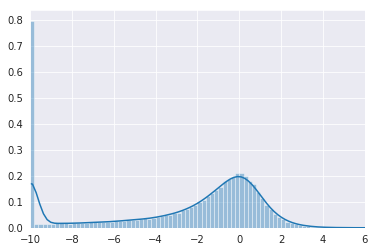

In [22]:
sns.distplot(rep1_zsvc.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

## Comparison of Data Types


In [23]:
# Unstack and join all level 4 data types
joiner = pd.DataFrame(rep1_lfcpc.data_df.unstack()).join(pd.DataFrame(rep1_zspc.data_df.unstack()), rsuffix='ZSPC', lsuffix='LFCPC').join(pd.DataFrame(rep1_lfcvc.data_df.unstack())).join(pd.DataFrame(rep1_zsvc.data_df.unstack()), rsuffix='ZSVC', lsuffix='LFCVC')

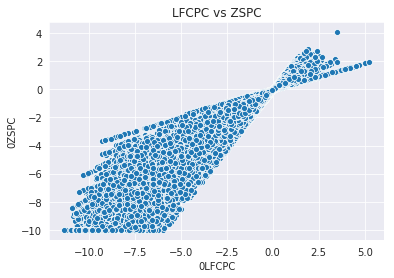

In [24]:
sns.scatterplot(x="0LFCPC", y="0ZSPC",data=joiner)
plt.title('LFCPC vs ZSPC')
plt.show()

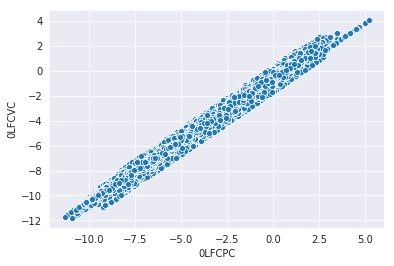

In [25]:
sns.scatterplot(x="0LFCPC", y="0LFCVC",data=joiner)
plt.show()

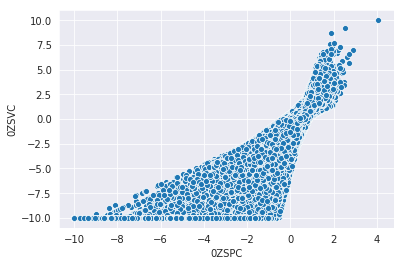

In [26]:
sns.scatterplot(x="0ZSPC", y="0ZSVC",data=joiner)
plt.show()

# Level 4 (ZSPC, ZSVC, LFCPC, LFCVC) to Level 5 (MODZ, MODZ.COMBAT)
## Rationale 

From level 4 to 5, we collapse our biological replcates (usually 2 or 3) using a weighted average, and adjust for batch effects in our cell lines using COMBAT

*Weighted Aggregate (ModZ)*. This procedure takes into account the correlation of each replicate to each other replicate, so that if there is an outlier profile at level 4 it will be weighted less heavily in the level 5 signature. This is done by first calculating a pairwise spearman correlation matrix between the three replicates. The diagonal of this matrix is set to 0, and then sums are taken across each row. These raw weights are normalized so that the sum of the weights is 1. Each profile is multiplied by its respective weight, and then the profiles are added together to create a signature. 


\begin{equation*}
Y = \sum_{i=1}^{N}b_{i} \times Z_{i}; \text{ where }\\ 
b_{i} = \frac{\sum_{j \neq i }\rho_{i,j}}{\sum_{i \neq j } \sum \rho}
\end{equation*}


In [27]:
gct_list = [rep1_zspc, rep2_zspc, rep3_zspc]
all_ds, combat_adjusted_gct_list = batch_adjust.combat_by_group(gct_list, col_group='pert_well', batch_field='pool_id')
modz_zspc_combat, zspc_cc_q75_df, [zspc_weights, zspc_raw_weights] = distil.calculate_modz(gct_list=combat_adjusted_gct_list)

In [28]:
modz_zspc_combat.data_df.head()

,PASG003_CS551:A01:A01,PASG003_CS551:A01:A02,PASG003_CS551:A01:A03,PASG003_CS551:A01:A04,PASG003_CS551:A01:A05,PASG003_CS551:A01:A06,PASG003_CS551:A01:A07,PASG003_CS551:A01:A08,PASG003_CS551:A01:A09,PASG003_CS551:A01:A10,...,PASG003_CS551:A01:P15,PASG003_CS551:A01:P16,PASG003_CS551:A01:P17,PASG003_CS551:A01:P18,PASG003_CS551:A01:P19,PASG003_CS551:A01:P20,PASG003_CS551:A01:P21,PASG003_CS551:A01:P22,PASG003_CS551:A01:P23,PASG003_CS551:A01:P24
rid,,,,,,,,,,,,,,,,,,,,,
c-1,0.136402,0.478354,0.445763,-0.492137,0.353012,0.721127,-3.193041,-1.951913,0.420352,0.950283,...,0.074159,0.223539,0.556018,0.596650,-3.223396,0.185692,0.684564,-3.314808,0.545786,0.282528
c-10,0.042032,0.125929,0.307676,-0.272831,0.714742,0.757319,-1.426432,-0.529707,-0.063798,0.608808,...,-0.186128,0.442067,0.344028,0.458228,-0.153689,0.854923,0.847729,-0.757564,0.515573,0.200888
c-100,-0.326162,0.134447,0.309741,0.362130,0.280496,0.505989,-2.153981,-1.056417,0.606755,0.428413,...,0.216541,0.078549,0.461442,0.211098,-0.002499,-0.102693,0.034695,-0.211202,-0.154503,-0.173077
c-101,-0.257761,0.089062,-0.103113,0.247280,-0.066976,0.261426,-2.744771,-0.725334,0.355549,0.565882,...,0.325803,0.023258,0.478041,0.462452,-0.125368,0.181547,0.543459,-0.049771,-0.095220,-0.690193
c-102,0.010460,0.377451,0.257792,-0.970230,0.487389,0.826868,-2.992526,-2.261832,0.353446,0.683412,...,-0.792218,0.013203,0.679522,0.589794,-1.382994,0.064501,0.487135,-0.422800,0.141561,-0.033457


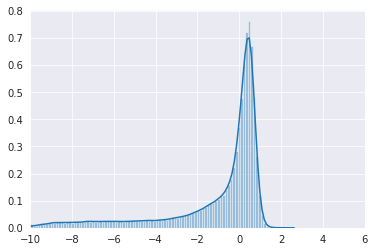

In [29]:
sns.distplot(modz_zspc_combat.data_df.unstack(), 100)
plt.xlim(-10,6)
plt.show()

### Calculating Signal Strength

With fully processed level 5 data we can calculate the signal strength of each signature. We do this by counting the number of cell lines measured with a zscore below our threshold of -2. We consider an active signature to be one with > 10 cell lines killed. With a few calculations we can calculate the % of the dataset that we consider active, which in this case is 42%


In [30]:
signal_strength = modz_zspc_combat.data_df[modz_zspc_combat.data_df < -2].count()

In [31]:

len(signal_strength[signal_strength > 10])

163

In [32]:
len(signal_strength[signal_strength > 10]) / float(len(signal_strength))

0.4244791666666667